In [6]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import unit_square
from time import sleep
import matplotlib.pyplot as plt
from netgen.occ import *


In [15]:
rect = MoveTo(-1,-1).Rectangle (2,2).Face()
rect.edges.Min(X).name="left"
circ = Circle ( (0.7, 0.0), 0.1).Face()
shape = rect-circ
mesh = Mesh (OCCGeometry( shape, dim=2).GenerateMesh(maxh=0.03)).Curve(5)
Draw (shape)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [45]:
tau = 0.005
tend = 2
u0 = exp(-400*(x**2 + y**2)) 
v0 = 0

fes = H1(mesh, order=3)
u,v = fes.TnT()
mform = u*v*dx
aform = grad(u)*grad(v)*dx

m = BilinearForm(mform).Assemble()
a = BilinearForm(aform).Assemble()
mstar = BilinearForm(mform+tau**2/4*aform).Assemble()
mstarinv = mstar.mat.Inverse(inverse="sparsecholesky")
f = LinearForm(fes).Assemble()

In [46]:
gfu = GridFunction(fes)
gfv = GridFunction(fes)

gfu.Set(u0)
gfv.Set(v0)

scene = Draw (gfu, deformation=True, order=3)

for j in range(int(tend/tau)):
    gfu.vec.data += tau/2 * gfv.vec
    gfv.vec.data += tau * mstarinv * (f.vec - a.mat * gfu.vec)
    gfu.vec.data += tau/2 * gfv.vec

    if j%2 == 0:
        scene.Redraw()
        # sleep(0.1)
scene.Redraw()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [41]:
energy_list = []
time_list = []
e_pot_list = []
e_kin_list = []
def ComputeEnergy():
    E_pot = 0.5 * a(gfu, gfu)  # Potential energy
    E_kin = 0.5 * m(gfv, gfv)  # Kinetic energy
    return E_pot, E_kin


for every step we calculate:
- half update on energy: $u^{j+1/2} = u^j + (tau/2)*v^j$
- velocity update step in the trapezoidal Newmark  $v^{j+1}    = v^j + tau * Mstar^{-1} * (f - A*u^{j+1/2})$

In [29]:
t = 0
numsteps = int(tend / tau)
for j in range(numsteps):
    gfu.vec.data += (tau/2) * gfv.vec # half step    
    gfv.vec.data += tau * mstarinv * (f.vec - a.mat * gfu.vec) # velocity update
    gfu.vec.data += (tau/2) * gfv.vec # second half step
    t += tau
    E_pot, E_kin = ComputeEnergy()
    energy_list.append(E_pot+E_kin)
    e_pot_list.append(E_pot)
    e_kin_list.append(E_kin)
    time_list.append(t)
    if j % 2 == 0:
        scene.Redraw()
scene.Redraw()


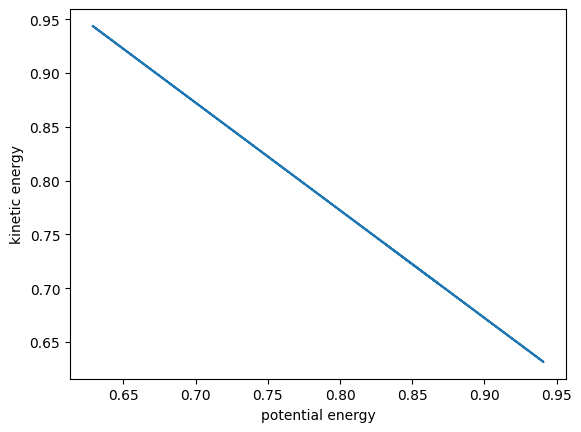

In [34]:
plt.figure()
plt.xlabel("potential energy")
plt.ylabel("kinetic energy")
plt.plot(e_pot_list, e_kin_list)
plt.show()


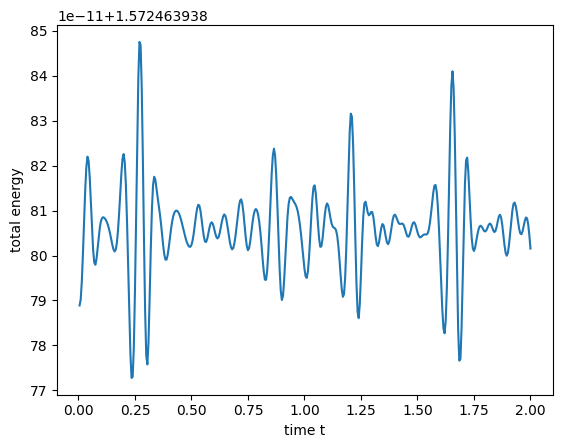

In [30]:
plt.figure()
plt.xlabel("time t")
plt.ylabel("total energy")
plt.plot(time_list, energy_list)
plt.show()


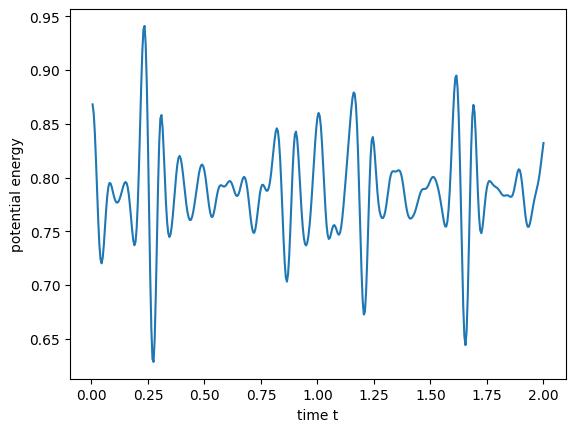

In [35]:
plt.figure()
plt.xlabel("time t")
plt.ylabel("potential energy")
plt.plot(time_list, e_pot_list)
plt.show()


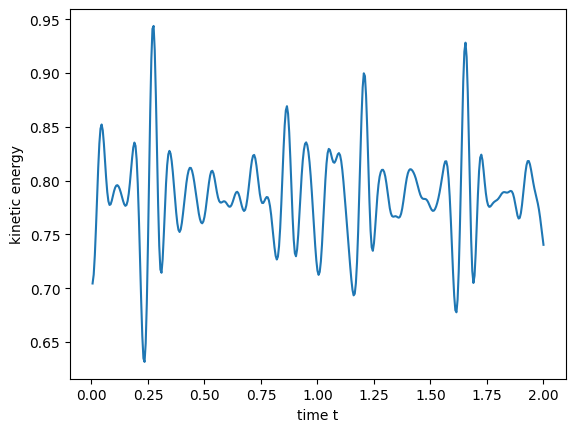

In [36]:
plt.figure()
plt.xlabel("time t")
plt.ylabel("kinetic energy")
plt.plot(time_list, e_kin_list)
plt.show()


## What changes if Neumann and Dirichlet b.c. are exchanged?

In [38]:
fes = H1(mesh, order=2, dirichlet="outer") # here is the dirichlet
u,v = fes.TnT()
mform = u*v*dx
aform = grad(u)*grad(v)*dx
m = BilinearForm(mform).Assemble()
a = BilinearForm(aform).Assemble()
mstar = BilinearForm(mform+tau**2/4*aform).Assemble()
mstarinv = mstar.mat.Inverse(inverse="sparsecholesky")
g = CoefficientFunction(5)
f = LinearForm(fes)
f += g * v * ds("outer")
f.Assemble()

In [44]:
fesD = H1(mesh, order=2, dirichlet="outer")
uD,vD = fesD.TnT()

mformD = uD*vD*dx
aformD = grad(uD)*grad(vD)*dx

mD = BilinearForm(mformD).Assemble()
aD = BilinearForm(aformD).Assemble()

mstarD = BilinearForm(mformD + (tau**2)/4*aformD).Assemble()
mstarinvD = mstarD.mat.Inverse(inverse="sparsecholesky")

g = CoefficientFunction(5)
fD = LinearForm(fesD)
fD += g * vD * ds("outer")
fD.Assemble()

gfuD = GridFunction(fesD)
gfvD = GridFunction(fesD)

gfuD.Set(u0)
gfvD.Set(v0)

sceneD = Draw(gfuD, deformation=True, order=3)

for j in range(int(tend/tau)):
    gfuD.vec.data += tau/2 * gfvD.vec
    gfvD.vec.data += tau * mstarinvD * (fD.vec - aD.mat * gfuD.vec)
    gfuD.vec.data += tau/2 * gfvD.vec
    
    if j%2 == 0:
        sceneD.Redraw()
sceneD.Redraw()


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [42]:
energy_list = []
time_list = []
e_pot_list = []
e_kin_list = []
t = 0
numsteps = int(tend / tau)
for j in range(numsteps):
    gfu.vec.data += (tau/2) * gfv.vec # half step    
    gfv.vec.data += tau * mstarinv * (f.vec - a.mat * gfu.vec) # velocity update
    gfu.vec.data += (tau/2) * gfv.vec # second half step
    t += tau
    E_pot, E_kin = ComputeEnergy()
    energy_list.append(E_pot+E_kin)
    e_pot_list.append(E_pot)
    e_kin_list.append(E_kin)
    time_list.append(t)
    if j % 2 == 0:
        scene.Redraw()
scene.Redraw()


In [ ]:
plt.figure()
plt.title("Energy in the Wave Equation")
plt.plot(time_list, energy_list, label="Total Energy")
plt.plot(time_list, e_pot_list, label="Potential Energy")
plt.plot(time_list, e_kin_list, label="Kinetic Energy")
plt.xlabel("Time t")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [48]:

tau = 0.005
tend = 2
k = 3
u0 = sin(k*y)*exp(-25*(x*x + y*y))
v0 = k*cos(k*y)*exp(-25*(x*x + y*y))
fes = H1(mesh, order=3)
u,v = fes.TnT()
mform = u*v*dx
aform = grad(u)*grad(v)*dx

m = BilinearForm(mform).Assemble()
a = BilinearForm(aform).Assemble()
mstar = BilinearForm(mform+tau**2/4*aform).Assemble()
mstarinv = mstar.mat.Inverse(inverse="sparsecholesky")
f = LinearForm(fes).Assemble()

In [49]:
gfu = GridFunction(fes)
gfv = GridFunction(fes)

gfu.Set(u0)
gfv.Set(v0)

scene = Draw (gfu, deformation=True, order=3)

for j in range(int(tend/tau)):
    gfu.vec.data += tau/2 * gfv.vec
    gfv.vec.data += tau * mstarinv * (f.vec - a.mat * gfu.vec)
    gfu.vec.data += tau/2 * gfv.vec

    if j%2 == 0:
        scene.Redraw()
        # sleep(0.1)
scene.Redraw()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…